In [60]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
import pandas as pd
import numpy as np
# Import libraries
import seaborn
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, LSTM
import tensorflow_addons as tfa
import os
import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline

### Read Dataset

In [62]:
data = pd.read_csv('/content/train.csv')
data

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202119-6909,2021-05-15,202119,6909,93,Arale,21274,13.3,Premium,2.0,35.0
1,202120-6909,2021-05-22,202120,6909,93,Arale,21274,13.3,Premium,0.0,70.0
2,202121-6909,2021-05-29,202121,6909,93,Arale,21274,13.3,Premium,3.0,137.0
3,202122-6909,2021-06-05,202122,6909,93,Arale,21274,13.3,Premium,0.0,274.0
4,202123-6909,2021-06-12,202123,6909,93,Arale,21274,13.3,Premium,0.0,333.0
...,...,...,...,...,...,...,...,...,...,...,...
15449,202317-247737,2023-04-29,202317,247737,15,Arale,10637,13.3,Premium,0.0,62.0
15450,202317-247737,2023-04-29,202317,247737,24,Arale,10637,13.3,Premium,0.0,3.0
15451,202318-247737,2023-05-06,202318,247737,3,Arale,10637,13.3,Premium,22.0,0.0
15452,202318-247737,2023-05-06,202318,247737,15,Arale,10637,13.3,Premium,68.0,78.0


# Data Processing

Cast column types

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15454 entries, 0 to 15453
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15454 non-null  object 
 1   date             15454 non-null  object 
 2   year_week        15454 non-null  int64  
 3   product_number   15454 non-null  int64  
 4   reporterhq_id    15454 non-null  int64  
 5   prod_category    15454 non-null  object 
 6   specs            15454 non-null  int64  
 7   display_size     15454 non-null  float64
 8   segment          15454 non-null  object 
 9   sales_units      14963 non-null  float64
 10  inventory_units  14961 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.3+ MB


In [64]:
data.columns

Index(['id', 'date', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'specs', 'display_size', 'segment', 'sales_units',
       'inventory_units'],
      dtype='object')

In [68]:
# Define the column type mapping
cate_columns = ['id', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'specs', 'display_size', 'segment']
data[cate_columns] = data[cate_columns].astype('str')
data['date'] = pd.to_datetime(data['date'])
data.dtypes

id                         object
date               datetime64[ns]
year_week                  object
product_number             object
reporterhq_id              object
prod_category              object
specs                      object
display_size               object
segment                    object
sales_units               float64
inventory_units           float64
dtype: object

In [69]:
product_ids = data.product_number.unique()
product_ids

array(['6909', '7896', '8883', '9870', '10857', '11844', '12831', '14805',
       '17766', '24675', '25662', '30597', '32571', '33558', '37506',
       '41454', '43428', '45402', '46389', '48363', '51324', '57246',
       '58233', '59220', '62181', '64155', '65142', '73038', '75012',
       '77973', '80934', '81921', '82908', '83895', '86856', '87843',
       '89817', '91791', '92778', '93765', '94752', '99687', '105609',
       '107583', '109557', '112518', '114492', '116466', '119427',
       '127323', '129297', '130284', '138180', '143115', '148050',
       '155946', '157920', '158907', '163842', '165816', '167790',
       '169764', '171738', '172725', '175686', '177660', '182595',
       '183582', '184569', '187530', '190491', '191478', '192465',
       '193452', '195426', '196413', '197400', '201348', '204309',
       '205296', '211218', '213192', '214179', '219114', '220101',
       '221088', '222075', '226023', '230958', '231945', '233919',
       '234906', '235893', '236880', '

In [70]:
def check_categorical_relation(frame):
  # Let's check the relation between product number and other categorical features
  gd = frame.groupby(['product_number']).nunique()

  print(gd['specs'].unique())
  print(gd['display_size'].unique())
  print(gd['prod_category'].unique())
  print(gd['segment'].unique())

check_categorical_relation(data)

[1]
[1]
[1]
[1]


In [ ]:
### Number of unique values from this columns for each product_number is 1
### It means they are not changing over time/place for certain product

In [75]:
# Preparing dummy dataframe, to insert datetime values and number of records between them
data_dates = pd.DataFrame([['983','2023-04-29','2023-04-29',43]])
data_dates.columns=["product_number","first_date","last_date","number_of_weeks"]
data_dates['first_date'] = pd.to_datetime(data_dates['first_date'])
data_dates['last_date'] = pd.to_datetime(data_dates['last_date'])

# Find first date of data, and last date for each product. Insert number of records (weeks) that are in the data
def find_min_max_of_product(product_id,data_dates,frame_main):
  data_cut = frame_main[frame_main['product_number']==product_id].sort_values('date',ascending=True).reset_index(drop=True)
  new_row = {"product_number":product_id,"first_date":data_cut['date'][0],
             "last_date":data_cut['date'][len(data_cut['date'])-1], "number_of_weeks":data_cut['date'].nunique()}
  data_dates = data_dates.append(new_row, ignore_index=True)
  return data_dates

for product_name in data['product_number'].unique():
  data_dates= find_min_max_of_product(product_name,data_dates, data)

# Calculate number of weeks that are possible between dates.
data_dates['weeks_between'] =(data_dates['last_date']-data_dates['first_date']).apply(lambda x: x/np.timedelta64(1,'W')+1)
data_dates= data_dates.drop(0).reset_index(drop=True)

# Show % value of missing weeks in the data
ds = data_dates[data_dates['number_of_weeks']!=data_dates['weeks_between']].sort_values('first_date',ascending=True)
ds['percentage'] = ds['number_of_weeks']/ds['weeks_between']*100
ds.sort_values('percentage',ascending=True).head(2)

,product_number,first_date,last_date,number_of_weeks,weeks_between,percentage
93,236880,2020-10-17,2023-05-06,70,134.0,52.238806
54,148050,2022-01-29,2023-05-06,41,67.0,61.194030


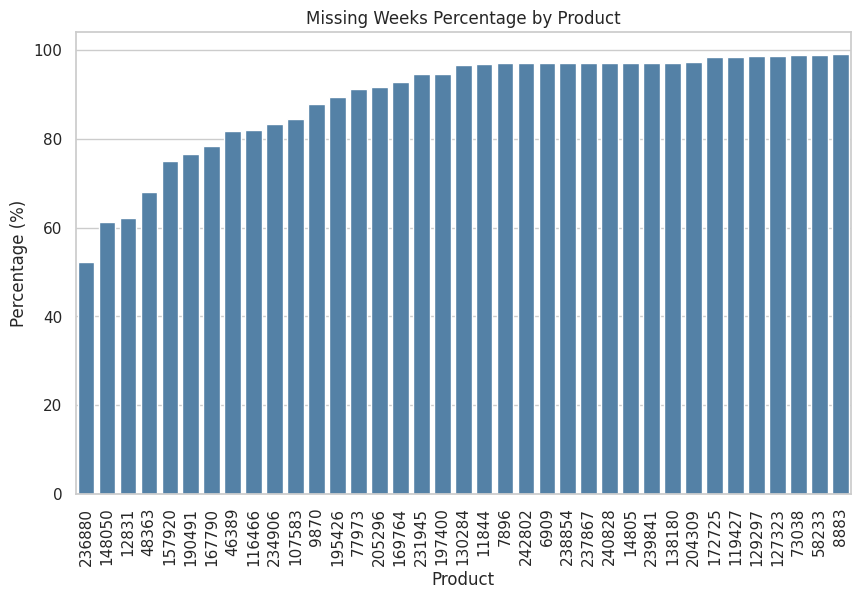

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_barplot(data):
    sns.set(style="whitegrid")
    sorted_data = data.sort_values('percentage',ascending=True)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=sorted_data.product_number, y='percentage', data=sorted_data,
                     color='steelblue')
    ax.set(xlabel='Product', ylabel='Percentage (%)')
    ax.set_title('Missing Weeks Percentage by Product')
    plt.xticks(rotation=90)
    plt.show()

draw_barplot(ds)

In [89]:
# Manually selected starting datetime for each product
# We set up restrictions for products having <90% data

dfs = []
config = {
    "236880":"202201",
    "148050":"202243",
    "12831":"202221",
    "48363":"202233",
    "157920":"202228",
    "190491":"202227",
    "46389":"202204",
    "116466":"202217",
    "234906":"202204"
}

# Clean some missing values
for product_id in product_ids:
  if product_id in list(config.keys()):
    abc = data[(data['product_number'] == product_id) & (data['year_week'] >= config[product_id]) & (data['year_week'] <= '202318')]
    dfs.append(abc)
  dfs.append(data[data['product_number'] == product_id])

df_col_merged = pd.concat(dfs, axis=0)
df_col_merged

In [14]:
# Sum up inventory units across all vendors to predict total sales for product
df_col_mergedd = df_col_merged.groupby(['date', 'year_week', 'product_number']).agg({'sales_units': 'sum', 'inventory_units':'sum'}).reset_index()
df_col_mergedd

,date,year_week,product_number,sales_units,inventory_units
0,2019-04-13,201915,233919,2.0,20.0
1,2019-04-20,201916,233919,3.0,43.0
2,2019-04-27,201917,233919,122.0,184.0
3,2019-05-04,201918,233919,61.0,219.0
4,2019-05-11,201919,233919,33.0,133.0
...,...,...,...,...,...
7704,2023-05-06,202318,92778,36.0,92.0
7705,2023-05-06,202318,93765,47.0,31.0
7706,2023-05-06,202318,94752,11.0,374.0
7707,2023-05-06,202318,9870,10.0,111.0


In [91]:
def generate_year_week_list(start_year, start_week, end_year=2023, end_week=18):
    start_date = datetime.datetime.strptime(f'{start_year}-W{start_week}-1', '%Y-W%W-%w')
    end_date = datetime.datetime.strptime(f'{end_year}-W{end_week}-1', '%Y-W%W-%w')
    current_date = start_date
    year_week_list = []
    
    while current_date <= end_date:
        year = current_date.isocalendar()[0]
        week = current_date.isocalendar()[1]
        year_week_list.append((year, f'{week:02}'))  # Format week number with leading zeros
        current_date += datetime.timedelta(weeks=1)

    df = pd.DataFrame(year_week_list, columns=['Year', 'Week'])
  
    return df

In [93]:
import datetime

# Generate datetimes for few missing points
dfs = []
for product_id in df_col_mergedd.product_number.unique():
    da = df_col_mergedd[df_col_mergedd['product_number']==product_id]

    da = da.sort_values("year_week", ascending=True)
    year_week = da.head(1)['year_week'].values[0]

    start_year = year_week[:4]
    start_week = year_week[-2:]

    ab = generate_year_week_list(int(start_year),int(start_week))
    ab["year_week"] = ab["Year"].astype(str) + ab['Week'].astype(str)
    
    abc = ab.merge(da, on='year_week', how='left')
    dfs.append(abc)

In [95]:
df_col = pd.concat(dfs, axis=0)
df_col

,Year,Week,year_week,date,product_number,sales_units,inventory_units
0,2019,16,201916,2019-04-20,233919,3.0,43.0
1,2019,17,201917,2019-04-27,233919,122.0,184.0
2,2019,18,201918,2019-05-04,233919,61.0,219.0
3,2019,19,201919,2019-05-11,233919,33.0,133.0
4,2019,20,201920,2019-05-18,233919,142.0,310.0
...,...,...,...,...,...,...,...
27,2023,14,202314,2023-04-08,107583,16.0,504.0
28,2023,15,202315,2023-04-15,107583,77.0,245.0
29,2023,16,202316,2023-04-22,107583,136.0,443.0
30,2023,17,202317,2023-04-29,107583,115.0,297.0


In [96]:
# Fill NA with previous calues, we fix it in next steps
print(df_col.isna().sum())
df_col.fillna(method='ffill', inplace = True)
print(df_col.isna().sum())

Year                 0
Week                 0
year_week            0
date               352
product_number     352
sales_units        352
inventory_units    352
dtype: int64
Year               0
Week               0
year_week          0
date               0
product_number     0
sales_units        0
inventory_units    0
dtype: int64


In [98]:
# Set all dates values that are possible for all products

def fix_date(data):
  sample = data.sort_values('year_week',ascending=True).reset_index(drop=True)
  for i in range(len(sample)-1):
    sample['date'][i+1] = sample['date'][i] + datetime.timedelta(weeks = 1)
  return sample

df_col['date'] = pd.to_datetime(df_col['date'])
dfs = []
for product_id in df_col.product_number.unique():
    da = df_col[df_col['product_number']==product_id]
    ab = fix_date(da)
    dfs.append(ab)
df_col = pd.concat(dfs, axis=0)
df_col

,Year,Week,year_week,date,product_number,sales_units,inventory_units
0,2019,16,201916,2019-04-20,233919,3.0,43.0
1,2019,17,201917,2019-04-27,233919,122.0,184.0
2,2019,18,201918,2019-05-04,233919,61.0,219.0
3,2019,19,201919,2019-05-11,233919,33.0,133.0
4,2019,20,201920,2019-05-18,233919,142.0,310.0
...,...,...,...,...,...,...,...
27,2023,14,202314,2023-04-08,107583,16.0,504.0
28,2023,15,202315,2023-04-15,107583,77.0,245.0
29,2023,16,202316,2023-04-22,107583,136.0,443.0
30,2023,17,202317,2023-04-29,107583,115.0,297.0


In [99]:
# Check if there are duplications after our fixing
for product_id in df_col.product_number.unique():
    da = df_col[df_col['product_number']==product_id]
    duplicate_dates = da[da.duplicated('date')]
    if len(duplicate_dates)>0:
      print(duplicate_dates)

In [31]:
df_col.to_csv('data.csv')

In [100]:
# Read dataset and set Date as the index
inventory_data = pd.read_csv('/content/data.csv', usecols =['product_number','inventory_units', "date", "Year", "Week"], parse_dates=["date"], index_col=["date"]).sort_index()
inventory_units = pd.DataFrame(inventory_data[["product_number","inventory_units"]])
inventory_units.head() 

,product_number,inventory_units
date,,
2021-05-15,6909,35.0
2021-05-22,6909,70.0
2021-05-29,6909,137.0
2021-06-05,6909,274.0
2021-06-12,6909,333.0


In [37]:
#Get the timesteps and prices
timesteps = inventory_units.index.to_numpy()
inventory = inventory_units["inventory_units"].to_numpy()

timesteps[:10], inventory[:10]

(array(['2021-05-15T00:00:00.000000000', '2021-05-22T00:00:00.000000000',
        '2021-05-29T00:00:00.000000000', '2021-06-05T00:00:00.000000000',
        '2021-06-12T00:00:00.000000000', '2021-06-19T00:00:00.000000000',
        '2021-06-26T00:00:00.000000000', '2021-07-03T00:00:00.000000000',
        '2021-07-10T00:00:00.000000000', '2021-07-17T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([ 35.,  70., 137., 274., 333., 349., 328., 288., 234., 131.]))

In [38]:
# Create train and test splits  for time series data
split_size = int(0.8 * len(inventory)) # 90% train, 10% test

# Create train data splits 
X_train, y_train = timesteps[:split_size], inventory[:split_size]

# Create test data splits 
X_test, y_test = timesteps[split_size:], inventory[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(83, 21, 83, 21)

In [105]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Inventory")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

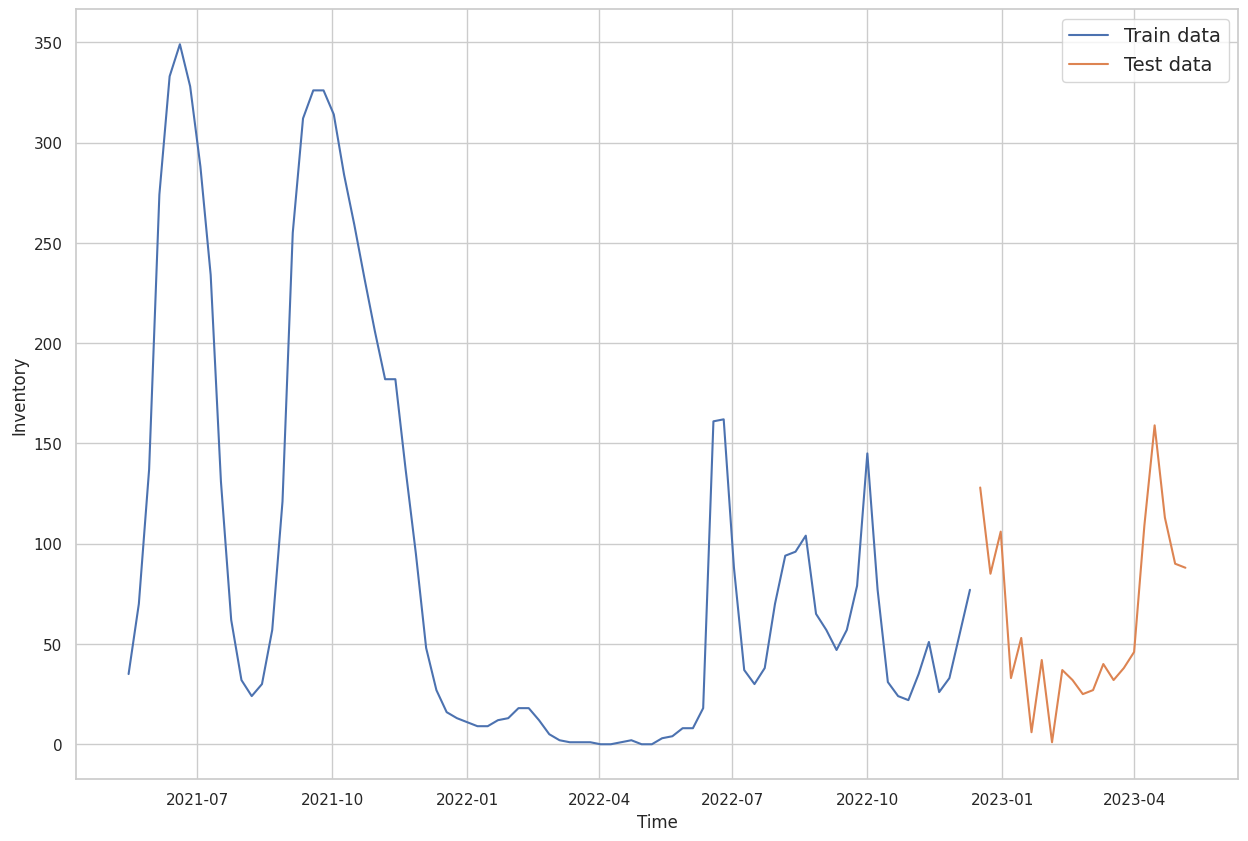

In [106]:
fig = plt.figure(figsize=(15,10))
plot_time_series(timesteps=X_train, values=y_train, format='-', label="Train data")
plot_time_series(timesteps=X_test, values=y_test, format='-', label="Test data")

#Baseline model


In [107]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:]

(array([128.,  85., 106.,  33.,  53.,   6.,  42.,   1.,  37.,  32.]),
 array([ 25.,  27.,  40.,  32.,  38.,  46., 109., 159., 113.,  90.]))

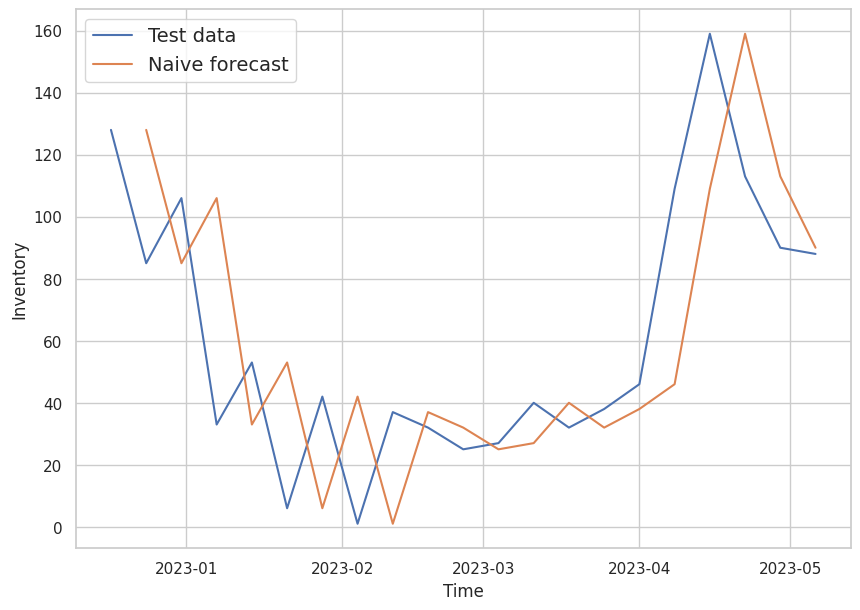

In [108]:
# Plot test data and naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test,  format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

In [109]:
# Create R-squared function
def R_squared(y_true, y_pred):
  """
  Implement R-squared
  """
  metric = tfa.metrics.r_square.RSquare()
  metric.update_state(y_true, y_pred)
  result = metric.result()
  return result

# Create Relative Absolute Error
def relative_absolute_error(y_true, y_pred):
    numerator = np.sum(np.abs(y_pred - y_true))
    denominator = np.sum(np.abs(np.mean(y_true) - y_true))
    return numerator / denominator

# Create Relative Squared Error
def relative_squared_error(y_true, y_pred):
    numerator = np.sum((y_true-y_pred)**2)
    denominator = np.sum((y_true - np.mean(y_true))**2)
    return numerator / denominator

In [110]:
def evaluate_preds(y_true, y_pred):
  # case data float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  r_squared = R_squared(y_true, y_pred)
  rae = relative_absolute_error(y_true, y_pred)
  rse = relative_squared_error(y_true, y_pred)

  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "rae": rae,
          "rse": rse,
          "r-squared": r_squared.numpy()}

In [111]:
# Evaluate naive model
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 27.5,
 'mse': 1201.5,
 'rmse': 34.66266,
 'rae': 0.8010485,
 'rse': 0.7427258,
 'r-squared': 0.2572744}

In [112]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 4 # Use 4 month timesteps to predict the horizon

In [113]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]
     

In [114]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=4, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [115]:
full_windows, full_labels = make_windows(inventory, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(100, 100)

In [116]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [ 35.  70. 137. 274.] -> Label: [333.]
Window: [ 70. 137. 274. 333.] -> Label: [349.]
Window: [137. 274. 333. 349.] -> Label: [328.]


In [117]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.1):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [118]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(90, 10, 90, 10)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[ 35.,  70., 137., 274.],
        [ 70., 137., 274., 333.],
        [137., 274., 333., 349.],
        [274., 333., 349., 328.],
        [333., 349., 328., 288.]]),
 array([[333.],
        [349.],
        [328.],
        [288.],
        [234.]]))

In [ ]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [ ]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(HORIZON)      
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(
                optimizer=tf.keras.optimizers.Adam(),
                loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

# Fit model
model_1.fit(x=train_windows, # train windows of 4 timesteps of maize prices
            y=train_labels, # horizon value of 1
            epochs=100,
            verbose=1,
            batch_size=8,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
 1/12 [=>............................] - ETA: 10s - loss: 16890.5527 - root_mean_squared_error: 129.9637

12/12 [==============================] - 2s 58ms/step - loss: 12969.3916 - root_mean_squared_error: 113.8832 - val_loss: 4234.3950 - val_root_mean_squared_error: 65.0722
Epoch 2/100
 1/12 [=>............................] - ETA: 0s - loss: 6999.6108 - root_mean_squared_error: 83.6637

12/12 [==============================] - 0s 44ms/step - loss: 6637.9863 - root_mean_squared_error: 81.4738 - val_loss: 2578.3911 - val_root_mean_squared_error: 50.7779
Epoch 3/100
 1/12 [=>............................] - ETA: 0s - loss: 1126.1641 - root_mean_squared_error: 33.5584

12/12 [==============================] - 1s 49ms/step - loss: 4127.9819 - root_mean_squared_error: 64.2494 - val_loss: 1766.4314 - val_root_mean_squared_error: 42.0289
Epoch 4/100
 1/12 [=>............................] - ETA: 0s - loss: 448.8884 - root_mean_squared_error: 21.1870

12/12 [==============================] - 0s 45ms/step - loss: 3050.7383 - root_mean_squared_error: 55.2335 - val_loss: 1490.9219 - val_root_mean_squared_error: 38.6125
Epoch 5/100
 1/12 [=>............................] - ETA: 0s - loss: 3810.4058 - root_mean_squared_error: 61.7285

12/12 [==============================] - 1s 46ms/step - loss: 2768.5767 - root_mean_squared_error: 52.6173 - val_loss: 1389.9987 - val_root_mean_squared_error: 37.2827
Epoch 6/100
 1/12 [=>............................] - ETA: 0s - loss: 4602.1069 - root_mean_squared_error: 67.8388

12/12 [==============================] - 1s 46ms/step - loss: 2484.8057 - root_mean_squared_error: 49.8478 - val_loss: 1320.4617 - val_root_mean_squared_error: 36.3382
Epoch 7/100
 1/12 [=>............................] - ETA: 0s - loss: 1597.9736 - root_mean_squared_error: 39.9747

12/12 [==============================] - 1s 51ms/step - loss: 2147.2161 - root_mean_squared_error: 46.3381 - val_loss: 1260.1572 - val_root_mean_squared_error: 35.4987
Epoch 8/100
 1/12 [=>............................] - ETA: 0s - loss: 235.7634 - root_mean_squared_error: 15.3546

12/12 [==============================] - 1s 68ms/step - loss: 1914.9719 - root_mean_squared_error: 43.7604 - val_loss: 1243.9677 - val_root_mean_squared_error: 35.2699
Epoch 9/100
 1/12 [=>............................] - ETA: 0s - loss: 899.3676 - root_mean_squared_error: 29.9895

12/12 [==============================] - 1s 64ms/step - loss: 1767.3068 - root_mean_squared_error: 42.0393 - val_loss: 1217.8018 - val_root_mean_squared_error: 34.8970
Epoch 10/100
12/12 [==============================] - 0s 9ms/step - loss: 1652.9440 - root_mean_squared_error: 40.6564 - val_loss: 1219.7900 - val_root_mean_squared_error: 34.9255
Epoch 11/100
 1/12 [=>............................] - ETA: 0s - loss: 776.2308 - root_mean_squared_error: 27.8609

12/12 [==============================] - 1s 66ms/step - loss: 1551.3253 - root_mean_squared_error: 39.3869 - val_loss: 1179.4247 - val_root_mean_squared_error: 34.3428
Epoch 12/100
 1/12 [=>............................] - ETA: 0s - loss: 1426.4683 - root_mean_squared_error: 37.7686

12/12 [==============================] - 0s 45ms/step - loss: 1461.9561 - root_mean_squared_error: 38.2355 - val_loss: 1158.4108 - val_root_mean_squared_error: 34.0354
Epoch 13/100
12/12 [==============================] - 0s 6ms/step - loss: 1405.0011 - root_mean_squared_error: 37.4833 - val_loss: 1162.7947 - val_root_mean_squared_error: 34.0998
Epoch 14/100
 1/12 [=>............................] - ETA: 0s - loss: 824.3466 - root_mean_squared_error: 28.7114

12/12 [==============================] - 1s 46ms/step - loss: 1355.1407 - root_mean_squared_error: 36.8122 - val_loss: 1155.7600 - val_root_mean_squared_error: 33.9965
Epoch 15/100
12/12 [==============================] - 0s 5ms/step - loss: 1319.1841 - root_mean_squared_error: 36.3206 - val_loss: 1162.2327 - val_root_mean_squared_error: 34.0915
Epoch 16/100
12/12 [==============================] - 0s 6ms/step - loss: 1300.5996 - root_mean_squared_error: 36.0638 - val_loss: 1157.4901 - val_root_mean_squared_error: 34.0219
Epoch 17/100
 1/12 [=>............................] - ETA: 0s - loss: 611.3196 - root_mean_squared_error: 24.7249

12/12 [==============================] - 0s 45ms/step - loss: 1256.7190 - root_mean_squared_error: 35.4502 - val_loss: 1155.7515 - val_root_mean_squared_error: 33.9963
Epoch 18/100
12/12 [==============================] - 0s 7ms/step - loss: 1235.3716 - root_mean_squared_error: 35.1479 - val_loss: 1156.4147 - val_root_mean_squared_error: 34.0061
Epoch 19/100
 1/12 [=>............................] - ETA: 0s - loss: 330.1220 - root_mean_squared_error: 18.1693

12/12 [==============================] - 0s 45ms/step - loss: 1241.7063 - root_mean_squared_error: 35.2379 - val_loss: 1154.2671 - val_root_mean_squared_error: 33.9745
Epoch 20/100
 1/12 [=>............................] - ETA: 0s - loss: 1022.0314 - root_mean_squared_error: 31.9692

12/12 [==============================] - 1s 77ms/step - loss: 1199.3474 - root_mean_squared_error: 34.6316 - val_loss: 1144.1078 - val_root_mean_squared_error: 33.8247
Epoch 21/100
11/12 [==========================>...] - ETA: 0s - loss: 1214.2667 - root_mean_squared_error: 34.8463

12/12 [==============================] - 1s 99ms/step - loss: 1200.3229 - root_mean_squared_error: 34.6457 - val_loss: 1143.3206 - val_root_mean_squared_error: 33.8130
Epoch 22/100
 1/12 [=>............................] - ETA: 0s - loss: 888.3473 - root_mean_squared_error: 29.8052

12/12 [==============================] - 0s 43ms/step - loss: 1150.6672 - root_mean_squared_error: 33.9215 - val_loss: 1120.1775 - val_root_mean_squared_error: 33.4691
Epoch 23/100
 1/12 [=>............................] - ETA: 0s - loss: 1400.4751 - root_mean_squared_error: 37.4229

12/12 [==============================] - 1s 47ms/step - loss: 1130.7357 - root_mean_squared_error: 33.6264 - val_loss: 1119.3702 - val_root_mean_squared_error: 33.4570
Epoch 24/100
 1/12 [=>............................] - ETA: 0s - loss: 638.4828 - root_mean_squared_error: 25.2682

12/12 [==============================] - 1s 47ms/step - loss: 1117.2277 - root_mean_squared_error: 33.4250 - val_loss: 1115.5406 - val_root_mean_squared_error: 33.3997
Epoch 25/100
 1/12 [=>............................] - ETA: 0s - loss: 608.0404 - root_mean_squared_error: 24.6585

12/12 [==============================] - 1s 46ms/step - loss: 1099.6617 - root_mean_squared_error: 33.1611 - val_loss: 1097.5262 - val_root_mean_squared_error: 33.1289
Epoch 26/100
 1/12 [=>............................] - ETA: 0s - loss: 493.2064 - root_mean_squared_error: 22.2083

12/12 [==============================] - 0s 44ms/step - loss: 1085.5344 - root_mean_squared_error: 32.9474 - val_loss: 1092.5626 - val_root_mean_squared_error: 33.0539
Epoch 27/100
 1/12 [=>............................] - ETA: 0s - loss: 2862.0681 - root_mean_squared_error: 53.4983

12/12 [==============================] - 1s 45ms/step - loss: 1059.1403 - root_mean_squared_error: 32.5444 - val_loss: 1073.3528 - val_root_mean_squared_error: 32.7621
Epoch 28/100
 1/12 [=>............................] - ETA: 0s - loss: 939.2245 - root_mean_squared_error: 30.6468

12/12 [==============================] - 0s 42ms/step - loss: 1034.9875 - root_mean_squared_error: 32.1712 - val_loss: 1046.0653 - val_root_mean_squared_error: 32.3429
Epoch 29/100
 1/12 [=>............................] - ETA: 0s - loss: 2705.5381 - root_mean_squared_error: 52.0148

12/12 [==============================] - 0s 44ms/step - loss: 1006.3909 - root_mean_squared_error: 31.7237 - val_loss: 1023.0594 - val_root_mean_squared_error: 31.9853
Epoch 30/100
12/12 [==============================] - 0s 7ms/step - loss: 997.4387 - root_mean_squared_error: 31.5823 - val_loss: 1025.1538 - val_root_mean_squared_error: 32.0180
Epoch 31/100
12/12 [==============================] - 0s 7ms/step - loss: 976.1981 - root_mean_squared_error: 31.2442 - val_loss: 1032.8577 - val_root_mean_squared_error: 32.1381
Epoch 32/100
12/12 [==============================] - 0s 7ms/step - loss: 959.1030 - root_mean_squared_error: 30.9694 - val_loss: 1035.3866 - val_root_mean_squared_error: 32.1774
Epoch 33/100
12/12 [==============================] - 0s 5ms/step - loss: 956.9209 - root_mean_squared_error: 30.9341 - val_loss: 1037.1930 - val_root_mean_squared_error: 32.2055
Epoch 34/100
12/12 [==============================] - 0s 7ms/step - loss: 951.8339 - root_mean_squared_error: 30.851

12/12 [==============================] - 0s 44ms/step - loss: 910.1272 - root_mean_squared_error: 30.1683 - val_loss: 1018.2808 - val_root_mean_squared_error: 31.9105
Epoch 41/100
 1/12 [=>............................] - ETA: 0s - loss: 469.4083 - root_mean_squared_error: 21.6658

12/12 [==============================] - 1s 53ms/step - loss: 906.7090 - root_mean_squared_error: 30.1116 - val_loss: 1005.8647 - val_root_mean_squared_error: 31.7154
Epoch 42/100
12/12 [==============================] - 0s 9ms/step - loss: 904.4800 - root_mean_squared_error: 30.0746 - val_loss: 1008.1523 - val_root_mean_squared_error: 31.7514
Epoch 43/100
12/12 [==============================] - 0s 8ms/step - loss: 901.7382 - root_mean_squared_error: 30.0290 - val_loss: 1014.0631 - val_root_mean_squared_error: 31.8444
Epoch 44/100
12/12 [==============================] - 0s 7ms/step - loss: 905.2730 - root_mean_squared_error: 30.0878 - val_loss: 1007.9390 - val_root_mean_squared_error: 31.7481
Epoch 45/100
 1/12 [=>............................] - ETA: 0s - loss: 610.2980 - root_mean_squared_error: 24.7042

12/12 [==============================] - 1s 61ms/step - loss: 894.4876 - root_mean_squared_error: 29.9080 - val_loss: 993.3280 - val_root_mean_squared_error: 31.5171
Epoch 46/100
12/12 [==============================] - 0s 8ms/step - loss: 903.0395 - root_mean_squared_error: 30.0506 - val_loss: 1012.5685 - val_root_mean_squared_error: 31.8209
Epoch 47/100
12/12 [==============================] - 0s 7ms/step - loss: 896.6385 - root_mean_squared_error: 29.9439 - val_loss: 1020.1046 - val_root_mean_squared_error: 31.9391
Epoch 48/100
12/12 [==============================] - 0s 7ms/step - loss: 913.2514 - root_mean_squared_error: 30.2200 - val_loss: 1017.5919 - val_root_mean_squared_error: 31.8997
Epoch 49/100
12/12 [==============================] - 0s 7ms/step - loss: 890.6724 - root_mean_squared_error: 29.8441 - val_loss: 1019.7716 - val_root_mean_squared_error: 31.9339
Epoch 50/100
12/12 [==============================] - 0s 7ms/step - loss: 891.9708 - root_mean_squared_error: 29.8659 

In [ ]:
# Load the best performing model 1 and evaluate it
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

1/1 [==============================] - 0s 95ms/step - loss: 993.3280 - root_mean_squared_error: 31.5171


[993.3280029296875, 31.517107009887695]

In [ ]:
# Create a make prediction function
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

1/1 [==============================] - 0s 42ms/step


(10,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 19.855927,  25.456434,  45.12163 ,  30.15122 ,  36.93997 ,
         49.90355 , 126.61118 , 178.59026 ,  93.24521 ,  65.620926],
       dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 23.44179,
 'mse': 993.328,
 'rmse': 31.517107,
 'rae': 0.6234518,
 'rse': 0.5633794,
 'r-squared': 0.43662065}

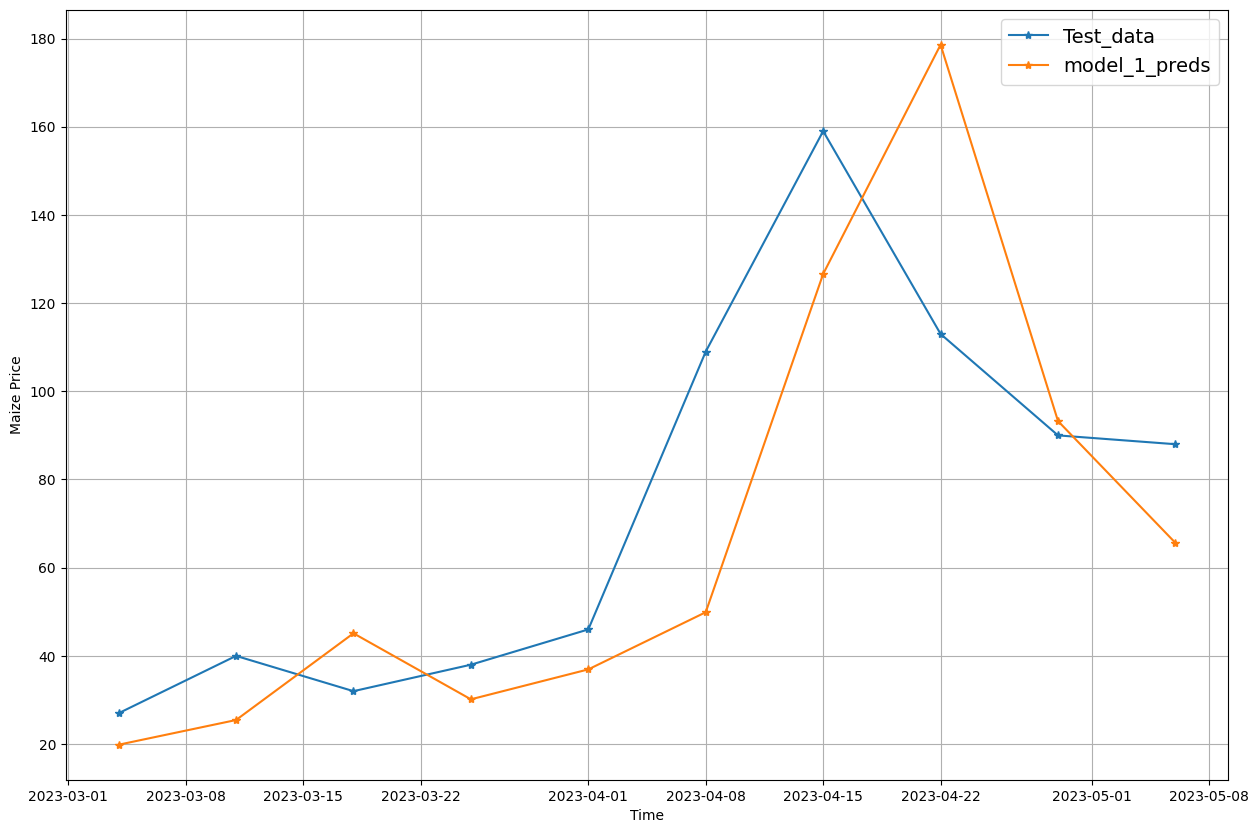

In [ ]:
plt.figure(figsize=(15, 10))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0],format="*-", label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, format="*-", label="model_1_preds")

## Future Forecast method

In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 4 # Use 4 month timesteps to predict the horizon
def make_future_forecast_data(X_all, y_all, model, window_size=WINDOW_SIZE):
    # Create an empty list for future forcast
    future_forecast = []

    # Create a empty list for future feature
    feature_values = []

    # Previous months
    last_window = list(y_all[-WINDOW_SIZE:])[::-1]
    last_window = last_window + [np.mean(last_window)] + [np.std(last_window)]
    print(last_window)

    total_train = X_all.copy()
    total_label = y_all.copy()

    for i in range(0, 13):
        pred_value = model.predict(np.array([last_window]))
        # Update train data before continuing training model
        total_train = np.concatenate((total_train, [last_window]), axis=0)
        total_label = np.concatenate((total_label, pred_value[0]), axis=0)

        model = train_model(total_train,total_label)
        # Save predicted value
        future_forecast.append(pred_value[0][0])
        #Save features
        feature_values.append(last_window)

        last_window = (list(pred_value[0]) + last_window[:-2])[:-1]
        last_window = last_window + [np.mean(last_window)] + [np.std(last_window)]

    return feature_values, future_forecast
    
# Write a train model function to reused it later
def train_model(X_all, y_all):

  tf.random.set_seed(42)

  # Construct model
  model = tf.keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(HORIZON)      
  ]) # give the model a name so we can save it

  # Compile model
  model.compile(
                  optimizer=tf.keras.optimizers.Adam(),
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

  # Fit model
  model.fit(x=X_all, # train windows of 4 timesteps of maize prices
            y=y_all, # horizon value of 1
            epochs=100,
            verbose=0,
            batch_size=8,) # create ModelCheckpoint callback to save best mo
  return model

In [ ]:
results = {}
features = {}
for project_id in df_col.product_number.unique():

    # Read dataset and set Date as the index
    inventory_data = pd.read_csv(f'/content/{project_id}.csv', usecols =['inventory_units', "date"], parse_dates=["date"], index_col=["date"]).sort_index()
    
    for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
        inventory_data[f"inventory_units+{i+1}"] = inventory_data["inventory_units"].shift(periods=i)

    # Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
    X_all = inventory_data.drop(["inventory_units"], axis=1).dropna()[:-1] # only want prices, our future model can be a univariate model
    X_all['Average'] = X_all.mean(axis=1)
    X_all['Std'] = X_all.std(axis=1)
    y_all = inventory_data.dropna()["inventory_units"][1:]

    model = train_model(X_all.to_numpy(), y_all.to_numpy())
    feature_values, predicted_values  = make_future_forecast_data(X_all=X_all,
                                                y_all=y_all,
                                                model=model,
                                                window_size=WINDOW_SIZE)
    
    results[project_id] = predicted_values
    features[project_id] = feature_values

    print(project_id, feature_values, predicted_values)

In [ ]:
results = {}
features = {}
for project_id in df_col.product_number.unique():

    # Read dataset and set Date as the index
    inventory_data = pd.read_csv(f'/content/{project_id}.csv', usecols =['inventory_units', "date"], parse_dates=["date"], index_col=["date"]).sort_index()
    
    for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
        inventory_data[f"inventory_units+{i+1}"] = inventory_data["inventory_units"].shift(periods=i)

    # Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
    X_all = inventory_data.drop(["inventory_units"], axis=1).dropna()[:-1] # only want prices, our future model can be a univariate model
    X_all['Average'] = X_all.mean(axis=1)
    X_all['Std'] = X_all.std(axis=1)
    y_all = inventory_data.dropna()["inventory_units"][1:]

    model = train_model(X_all.to_numpy(), y_all.to_numpy())
    feature_values, predicted_values  = make_future_forecast_data(X_all=X_all,
                                                y_all=y_all,
                                                model=model,
                                                window_size=WINDOW_SIZE)
    
    results[project_id] = predicted_values
    features[project_id] = feature_values

    print(project_id, feature_values, predicted_values)

In [ ]:
import csv

def save_dict_to_csv(dictionary, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=dictionary.keys())
        writer.writeheader()
        writer.writerow(dictionary)

# Save the dictionary to a CSV file
save_dict_to_csv(results, 'results.csv')
for key, value in results.items():
  results[key] = [round(i) for i in value]